In [44]:
%load_ext autoreload
%autoreload 2

,series,white_noise,series_seasonal_trend_factor,weekend_trend_factor,holiday_trend_factor,total_factor,value,day_of_year
date,,,,,,,,
2019-01-01,s_3,0.933390,0.604529,1.0,1.5,1.692784,169.278352,1
2019-01-01,s_2,0.946402,0.703397,1.0,1.5,0.998544,99.854437,1
2019-01-01,s_1,0.964324,0.802264,1.0,1.5,0.580232,58.023197,1
2019-01-02,s_3,0.994360,0.603554,1.0,1.5,1.800451,180.045086,2
2019-01-02,s_2,0.903683,0.702666,1.0,1.5,0.952481,95.248114,2


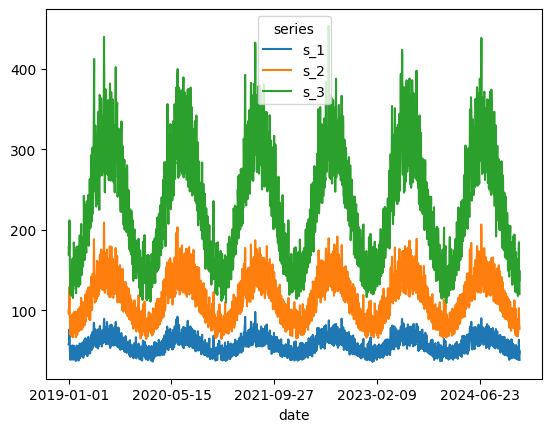

In [24]:
import pandas as pd

df = pd.read_csv("data\\non_linear_time_series.csv", index_col=0)
series = ["s_1", "s_2", "s_3"]
display(df.head())
df.reset_index( inplace=True)


df.pivot(columns="series", values="value", index="date").plot(legend=True)
                           #.plot(legend=True)
# .plot(legend=True)

df["date"] = pd.to_datetime(df["date"])



In [25]:


# melt the series and prepare for the model

df_demand = df[["date", "series", "value"]].copy()
df_demand["series_id"] = df_demand["series"]
# create exog dataframe for holiday and	weather
df_exog_temp = df[["date","weekend_trend_factor", "holiday_trend_factor", "day_of_year"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for s in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = s
    df_exog = pd.concat([df_exog, df_exog_brand])


display(df_demand.head())
display(df_exog.head())

C:\Users\Matty\AppData\Local\Temp\ipykernel_59132\4027802599.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


,date,series,value,series_id
0,2019-01-01,s_3,169.278352,s_3
1,2019-01-01,s_2,99.854437,s_2
2,2019-01-01,s_1,58.023197,s_1
3,2019-01-02,s_3,180.045086,s_3
4,2019-01-02,s_2,95.248114,s_2


,date,weekend_trend_factor,holiday_trend_factor,day_of_year,series_id
0,2019-01-01,1.00,1.500000,1,s_1
3,2019-01-02,1.00,1.500000,2,s_1
6,2019-01-03,1.00,1.447218,3,s_1
9,2019-01-04,1.15,1.401947,4,s_1
12,2019-01-05,1.30,1.347914,5,s_1


## Dataset

{'s_1': 2019-01-01    58.023197
2019-01-02    58.706334
2019-01-03    59.730792
2019-01-04    67.966845
2019-01-05    76.780999
                ...    
2023-12-28    43.819912
2023-12-29    53.899260
2023-12-30    64.311757
2023-12-31    64.665457
2024-01-01    50.582102
Freq: D, Name: s_1, Length: 1827, dtype: float64, 's_2': 2019-01-01     99.854437
2019-01-02     95.248114
2019-01-03    106.614142
2019-01-04    116.518344
2019-01-05    129.406493
                 ...    
2023-12-28     81.426109
2023-12-29     93.405181
2023-12-30    113.088910
2023-12-31    103.355570
2024-01-01     79.953807
Freq: D, Name: s_2, Length: 1827, dtype: float64, 's_3': 2019-01-01    169.278352
2019-01-02    180.045086
2019-01-03    175.063819
2019-01-04    201.353381
2019-01-05    211.810456
                 ...    
2023-12-28    140.368330
2023-12-29    140.786611
2023-12-30    185.986943
2023-12-31    202.787590
2024-01-01    127.262223
Freq: D, Name: s_3, Length: 1827, dtype: float64}
{'s_1':       

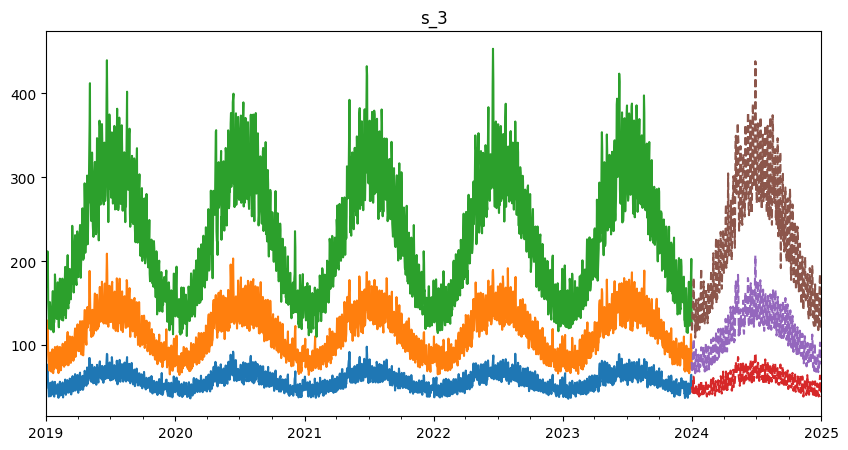

In [28]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2024-01-01"

mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


In [29]:


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [2,4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 6
[LightGBM] [Info] Start training from score 0.349340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

(            levels          lags  \
 0  [s_1, s_2, s_3]        [1, 2]   
 1  [s_1, s_2, s_3]        [1, 2]   
 2  [s_1, s_2, s_3]        [1, 2]   
 3  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 4  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 5  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 6  [s_1, s_2, s_3]        [1, 2]   
 7  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 8  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 9  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 
                                               params  \
 0  {'n_estimators': 531, 'max_depth': 6, 'learnin...   
 1  {'n_estimators': 706, 'max_depth': 12, 'learni...   
 2  {'n_estimators': 912, 'max_depth': 4, 'learnin...   
 3  {'n_estimators': 850, 'max_depth': 14, 'learni...   
 4  {'n_estimators': 1035, 'max_depth': 12, 'learn...   
 5  {'n_estimators': 1009, 'max_depth': 10, 'learn...   
 6  {'n_estimators': 351, 'max_depth': 6, 'learnin...   
 7  {'n_estimators': 643, 'max_depth': 7, 'learnin...   
 8  {'n_estimators': 652, 'max_depth': 10, 'learni...   
 9  {'n_estimators': 

c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_1' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2024-01-01 00:00:00.
    `exog` for series 's_1' starts at : 2024-01-01 00:00:00.
     Expected index       : 2024-01-02 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_2' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2024-01-01 00:00:00.
    `exog` for series 's_2' starts at : 2024-01-01 00:00:00.
     Expected index       : 2024-01-02 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', ca

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

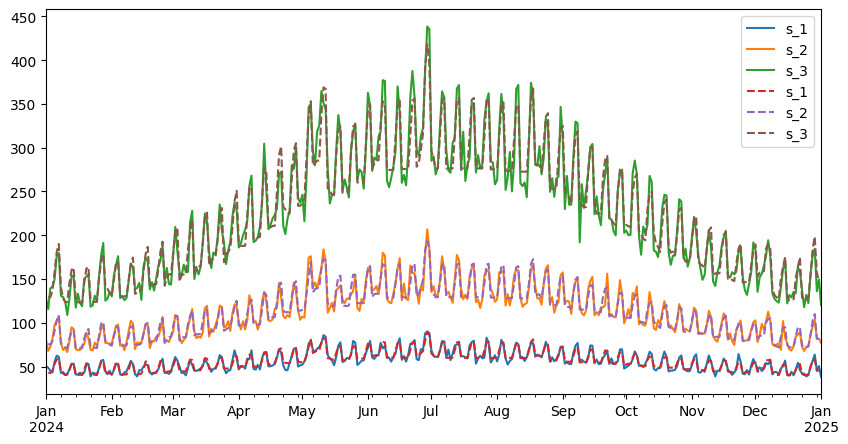

In [30]:
forecaster.plot_forecast()

In [ ]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15


AttributeError: 'ForecasterRecursiveMultiSeries' object has no attribute 'encoding_mapping'

In [50]:
fi.hierarchies

AttributeError: 'ForecasterMsExogFeatureImportance' object has no attribute 'hierarchies'